In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa as rosa
import os
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import statistics
from sklearn.utils import resample
from tensorflow.keras.callbacks import LearningRateScheduler

<h1>Setting Random Seeds</h1>

In [2]:
# Set the random seeds for replicating results over multiple runs.
np.random.seed(0)
tf.random.set_seed(0)

<h1>Importing Features from CSV</h1>

In [3]:
# Using first row as column header and first column as row header.
df = pd.read_csv("C:/Users/saide/OneDrive/Desktop/TDL/SER-RNN-final/RAVDESS_Librosa_RNN.csv", header=0, index_col=0)

# We used 36 features. Column of dataframe represents the features (36*median_num_frames), and -1 to avoid considering column indexes.
median_num_frames = (df.shape[1]-1)//36

# Rename target labels.
df['Emotion'].replace({"Neutral" : 1.0, "Happy" : 2.0, "Sad" : 3.0, "Angry" : 4.0, "Fearful" : 5.0, "Disgust" : 6.0, "Surprised" : 7.0}, inplace=True)

In [4]:
# Takes data samples of each class from dataframe into separate dataframes.
df_happy = df.loc[df.Emotion==2.0]
df_sad = df[df.Emotion==3.0]
df_angry = df[df.Emotion==4.0]
df_fearful = df[df.Emotion==5.0]
df_disgust = df[df.Emotion==6.0]
df_neutral = df[df.Emotion==1.0]
df_surprised = df[df.Emotion==7.0]

df_maj = pd.concat([df_happy, df_sad, df_angry, df_fearful, df_disgust, df_surprised])

# Extracts labels of majority classes.
y_maj = df_maj.iloc[0:1152, 36*median_num_frames].values
# Extract features of majority classes.
X_maj = df_maj.iloc[0:1152, list(range(36*median_num_frames))].values

# Split and stratify majority class samples for training and testing.
X_train_temp_maj, X_test_maj, y_train_temp_maj, y_test_maj = train_test_split(X_maj, y_maj, test_size=115, random_state=0, stratify=y_maj) # training split = 90%, test split = 10%

# Further split and stratify majority class training samples for training data for training and validating.
X_train_maj, X_val_maj, y_train_maj, y_val_maj = train_test_split(X_train_temp_maj, y_train_temp_maj, test_size=115, random_state=0, stratify=y_train_temp_maj) # training split = 80%, validation split = 10%

# Take minority data samples from dataframe to array.
neutral_array = df_neutral.to_numpy()

# Shuffle the data samples of minority class.
np.random.shuffle(neutral_array)

# Split minority class Neutral in 80:10:10 ratio.
train_neutral = neutral_array[0:76, :]
val_neutral = neutral_array[76:86, :]
test_neutral = neutral_array[86:96, :]

# Resampling Neutral data to match majority class samples.
train_neutral_resampled = resample(train_neutral, n_samples=154, replace=True, random_state=0)
val_neutral_resampled = resample(val_neutral, n_samples=19, replace=True, random_state=0)
test_neutral_resampled = resample(test_neutral, n_samples=19, replace=True, random_state=0)

# Separate features and target labels for Neutral data.
X_train_neutral = train_neutral_resampled[:, 0:36*median_num_frames]
X_val_neutral = val_neutral_resampled[:, 0:36*median_num_frames]
X_test_neutral = test_neutral_resampled[:, 0:36*median_num_frames]
y_train_neutral = train_neutral_resampled[:, 36*median_num_frames]
y_val_neutral = val_neutral_resampled[:, 36*median_num_frames]
y_test_neutral = test_neutral_resampled[:, 36*median_num_frames]

# Join upsampled minority data samples with majority data samples.
X_train = np.concatenate((X_train_maj, X_train_neutral), axis=0)
X_val = np.concatenate((X_val_maj, X_val_neutral), axis=0)
X_test = np.concatenate((X_test_maj, X_test_neutral), axis=0)
y_train = np.concatenate((y_train_maj, y_train_neutral), axis=0)
y_val = np.concatenate((y_val_maj, y_val_neutral), axis=0)
y_test = np.concatenate((y_test_maj, y_test_neutral), axis=0)

<h1>Scaling the Features</h1>

In [5]:
# Calculate the mean and standard deviation of the features.
mean_X = np.mean(X_train, axis=0)
std_X = np.std(X_train, axis=0)

# Standardize the inputs.
X_train_centered = (X_train - mean_X)/std_X
X_val_centered = (X_val - mean_X)/std_X
X_test_centered = (X_test - mean_X)/std_X

# Delete old variables to save space.
del X_train, X_val, X_test, X_train_temp_maj, y_train_temp_maj

print(X_train_centered.shape, y_train.shape)
print(X_val_centered.shape, y_val.shape)
print(X_test_centered.shape, y_test.shape)

(1076, 8280) (1076,)
(134, 8280) (134,)
(134, 8280) (134,)


<h1>One-hot Encoding the Labels</h1>

In [6]:
# One-Hot Encode the classes.
y_train_onehot = keras.utils.to_categorical(y_train)
y_val_onehot = keras.utils.to_categorical(y_val)
y_test_onehot = keras.utils.to_categorical(y_test)

<h1>Reshaping Input Arrays</h1>

RNNs require 3D arrays (tensors) for input. The three dimensions are batch (i.e. number of data samples), timesteps, and features per timestep.

In [7]:
# Reshaping X_train and X_test to 3D Numpy arrays for feeding into the RNN.
X_train_3D = np.reshape(X_train_centered, (X_train_centered.shape[0], median_num_frames, 36))
X_val_3D = np.reshape(X_val_centered, (X_val_centered.shape[0], median_num_frames, 36))
X_test_3D = np.reshape(X_test_centered, (X_test_centered.shape[0], median_num_frames, 36))

print(X_train_3D.shape, y_train.shape)
print(X_val_3D.shape, y_val.shape)
print(X_test_3D.shape, y_test.shape)

# Transposing tensors
X_train_3D_posed = tf.transpose(X_train_3D, perm=[0, 2, 1])
X_val_3D_posed = tf.transpose(X_val_3D, perm=[0, 2, 1])
X_test_3D_posed = tf.transpose(X_test_3D, perm=[0, 2, 1])

print(X_train_3D_posed.shape, y_train.shape)
print(X_val_3D_posed.shape, y_val.shape)
print(X_test_3D_posed.shape, y_test.shape)

(1076, 230, 36) (1076,)
(134, 230, 36) (134,)
(134, 230, 36) (134,)
(1076, 36, 230) (1076,)
(134, 36, 230) (134,)
(134, 36, 230) (134,)


<h1>Defining RNN Architecture</h1>

USing LSTM. We will use 36 LSTM cells for our 36 features at the input.

In [9]:
model = keras.models.Sequential()

model.add(
    keras.layers.LSTM( units=36,
                input_shape=(36, median_num_frames),
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                activation='tanh',
                recurrent_activation='sigmoid',
                dropout=0.30,
                recurrent_dropout=0.30,
                return_sequences=True))

model.add(
    keras.layers.LSTM( units=12,
                input_shape=(36, median_num_frames),
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                activation='tanh',
                recurrent_activation='sigmoid',
                dropout=0.30))

model.add(
    keras.layers.Dense( units=y_train_onehot.shape[1],
                input_dim=36,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                activation='softmax'))

<h1>Defining the Optimizer and Loss Function</h1>

We will use the Adam optimizer and the categorical crossentropy loss and a learning rate scheduler.

In [10]:
# Define the learning rate schedule. This can then be passed as the learning rate for the optimizer.
lrate = keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=0.01, decay_steps=1000, decay_rate=0.8)

adam_optimizer = keras.optimizers.Adam(learning_rate=lrate)

model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()])

<h1>Fitting the Model</h1>

In [11]:
# Training the RNN.
history = model.fit(X_train_3D_posed, y_train_onehot, batch_size=16, epochs=30, verbose=1, validation_data=(X_val_3D_posed, y_val_onehot)) # 80% training / 20% validation

print(history.history)

Epoch 1/30
68/68 [==============================] - 9s 47ms/step - loss: 1.6691 - categorical_accuracy: 0.4015 - val_loss: 1.5272 - val_categorical_accuracy: 0.4328
Epoch 2/30
68/68 [==============================] - 3s 39ms/step - loss: 1.2399 - categorical_accuracy: 0.5586 - val_loss: 1.4265 - val_categorical_accuracy: 0.4328
Epoch 3/30
68/68 [==============================] - 2s 34ms/step - loss: 0.9646 - categorical_accuracy: 0.6636 - val_loss: 1.3319 - val_categorical_accuracy: 0.5075
Epoch 4/30
68/68 [==============================] - 2s 36ms/step - loss: 0.8281 - categorical_accuracy: 0.7258 - val_loss: 1.5423 - val_categorical_accuracy: 0.4627
Epoch 5/30
68/68 [==============================] - 2s 33ms/step - loss: 0.7087 - categorical_accuracy: 0.7686 - val_loss: 1.4047 - val_categorical_accuracy: 0.5448
Epoch 6/30
68/68 [==============================] - 2s 36ms/step - loss: 0.5217 - categorical_accuracy: 0.8318 - val_loss: 1.4559 - val_categorical_accuracy: 0.5373
Epoch 7/30

<h1>Plotting the Accuracy Curves</h1>



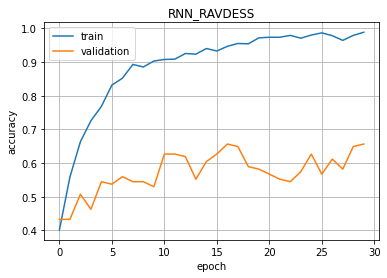

In [12]:
# Plot the training and validation accuracies vs. epochs for the latest loop iteration.
fig = plt.figure()
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('RNN_RAVDESS')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<h1>Plotting the Loss Curves</h1>

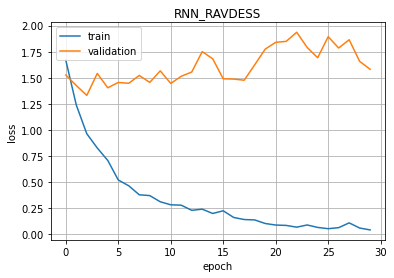

In [13]:
# Plot the training and validation losses vs. epochs for the latest loop iteration.
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('RNN_RAVDESS')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<h1>Evaluating the Model on Test Set</h1>

In [14]:
# Evaluate the model on the test data.
results = model.evaluate(X_test_3D_posed, y_test_onehot, batch_size=16)
print("test loss, test acc:", results)

9/9 [==============================] - 0s 21ms/step - loss: 1.6359 - categorical_accuracy: 0.6418
test loss, test acc: [1.6359246969223022, 0.641791045665741]


<h1>Saving the Model</h1>

In [ ]:
# Saving the model.
model.save('RNN_RAVDESS.h5')

# Save mean and standard deviation arrays of features.
np.save('mean_X.npy', mean_X)
np.save('std_X.npy', std_X)